In [2]:
import pandas as pd
import matplotlib.pyplot as plt

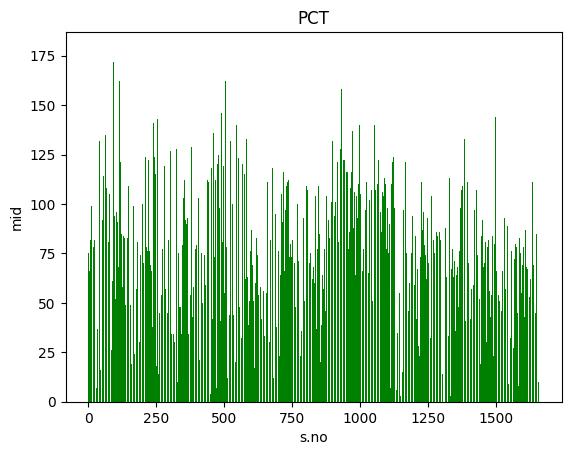

In [3]:
df = pd.read_csv("final1.csv")
df.columns
X = list(df.iloc[:, 0]) 
Y = list(df.iloc[:, 14])
plt.bar(X, Y, color='g') 
plt.title("PCT") 
plt.xlabel("s.no") 
plt.ylabel("mid") 
plt.show()

# Deep Neural Network

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [11]:
# Load data
data = df.copy()

# Adding new engineered features
data['Avg_Tutorial_Score'] = data[['T1', 'T2', 'T3', 'T4', 'T5']].mean(axis=1)
data['Total_Precomp_Score'] = data['Mid(100)'] + data['Tut (80)'] + data['PCT (180)']
data['Std_Dev_Tutorial_Scores'] = data[['T1', 'T2', 'T3', 'T4', 'T5']].std(axis=1)

# Selecting numerical score columns for features including new features
features = data[['Mid(100)', 'T1', 'T2', 'T3', 'T4', 'T5', 'Tut (80)', 'PCT (180)', 'Avg_Tutorial_Score', 'Total_Precomp_Score', 'Std_Dev_Tutorial_Scores']]
target = data['CT(300)']  # Target variable

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Define the model
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mean_absolute_error'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=150, batch_size=32, callbacks=[early_stopping])

# Evaluate the model
evaluation = model.evaluate(X_test, y_test)
print(f'Test Loss: {evaluation[0]}, Test MAE: {evaluation[1]}')


NameError: name 'Sequential' is not defined

As we can see the performance of a DNN did not work well for the data, so lets move on to some better approach.

# XGBoost Model

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error

data = df.copy()

# Adding new engineered features
data['Avg_Tutorial_Score'] = data[['T1', 'T2', 'T3', 'T4', 'T5']].mean(axis=1)
data['Total_Precomp_Score'] = data['Mid(100)'] + data['Tut (80)'] + data['PCT (180)']
data['Std_Dev_Tutorial_Scores'] = data[['T1', 'T2', 'T3', 'T4', 'T5']].std(axis=1)

# Selecting numerical score columns for features including new features
features = data[['Mid(100)', 'T1', 'T2', 'T3', 'T4', 'T5', 'Tut (80)', 'PCT (180)', 'Avg_Tutorial_Score', 'Total_Precomp_Score', 'Std_Dev_Tutorial_Scores']]
target = data['CT(300)']

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                             max_depth = 5, alpha = 10, n_estimators = 200)

xgb_model.fit(X_train, y_train)

# Evaluate the model
predictions = xgb_model.predict(X_test)
mae = np.mean(np.abs(predictions - y_test))
mse = mean_squared_error(y_test, predictions)
print(f'Test MAE: {mae}')
print(f'Test MSE: {mse}')

# Function to provide study suggestions based on performance thresholds

In [ ]:
# Function to provide study suggestions based on performance thresholds
def provide_study_suggestions(data, model, threshold='average'):
    features = data[['Mid(100)', 'T1', 'T2', 'T3', 'T4', 'T5', 'Tut (80)', 'PCT (180)', 'Avg_Tutorial_Score', 'Total_Precomp_Score', 'Std_Dev_Tutorial_Scores']]
    features_scaled = scaler.transform(features)
    predictions = model.predict(features_scaled)
    suggestions = []

    for i, row in data.iterrows():
        actual = row['CT(300)']
        predicted = predictions[i]
        if threshold == 'average':
            threshold_value = data['CT(300)'].mean()
        elif threshold == 'average+':
            threshold_value = data['CT(300)'].mean() + 10  # Adjust this value as needed
        elif threshold == 'average-':
            threshold_value = data['CT(300)'].mean() - 10  # Adjust this value as needed

        if predicted < threshold_value:  # Using predicted score to determine if suggestions are needed
            test_scores = row[['T1', 'T2', 'T3', 'T4', 'T5']]
            min_score_index = test_scores.argmin()
            min_topic = row[f'Topic-{min_score_index + 1}']
            suggestions.append((row['No.'], min_topic))
    return suggestions

study_suggestions = provide_study_suggestions(data, xgb_model)
print("XGB Model Suggestions")
print(study_suggestions)

study_suggestions = provide_study_suggestions(data, model)
print("DNN Model Suggestions")
print(study_suggestions)

Testing on Second Dataset

In [ ]:
df_alt = pd.read_csv("dataset2_final.csv")
data1 = df.copy()

# Adding new engineered features
data1['Avg_Tutorial_Score'] = data1[['T1', 'T2', 'T3', 'T4', 'T5']].mean(axis=1)
data1['Total_Precomp_Score'] = data1['Mid(100)'] + data1['Tut (80)'] + data1['PCT (180)']
data1['Std_Dev_Tutorial_Scores'] = data1[['T1', 'T2', 'T3', 'T4', 'T5']].std(axis=1)

# Selecting numerical score columns for features including new features
features = data1[['Mid(100)', 'T1', 'T2', 'T3', 'T4', 'T5', 'Tut (80)', 'PCT (180)', 'Avg_Tutorial_Score', 'Total_Precomp_Score', 'Std_Dev_Tutorial_Scores']]
target = data1['CT(300)']  # Target variable

# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

y_pred = xgb_model.predict(X_test)
print(y_pred)
y_pred1 = xgb_model.predict(X_train)
print(y_pred1)


In [ ]:
def mean_absolute_error(actual_values, predicted_values):
    """
    Calculate the Mean Absolute Error (MAE) between actual and predicted values.

    Parameters:
        actual_values (list): List of actual values.
        predicted_values (list): List of predicted values.

    Returns:
        float: Mean Absolute Error (MAE).
    """
    if len(actual_values) != len(predicted_values):
        raise ValueError("Length of actual_values and predicted_values must be the same.")

    error_sum = 0.0
    for actual, predicted in zip(actual_values, predicted_values):
        error_sum += abs(actual - predicted)

    mae = error_sum / len(actual_values)
    return mae

mae1 = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae1)

mae2 = mean_absolute_error(y_train, y_pred1)
print("Mean Absolute Error:", mae2)